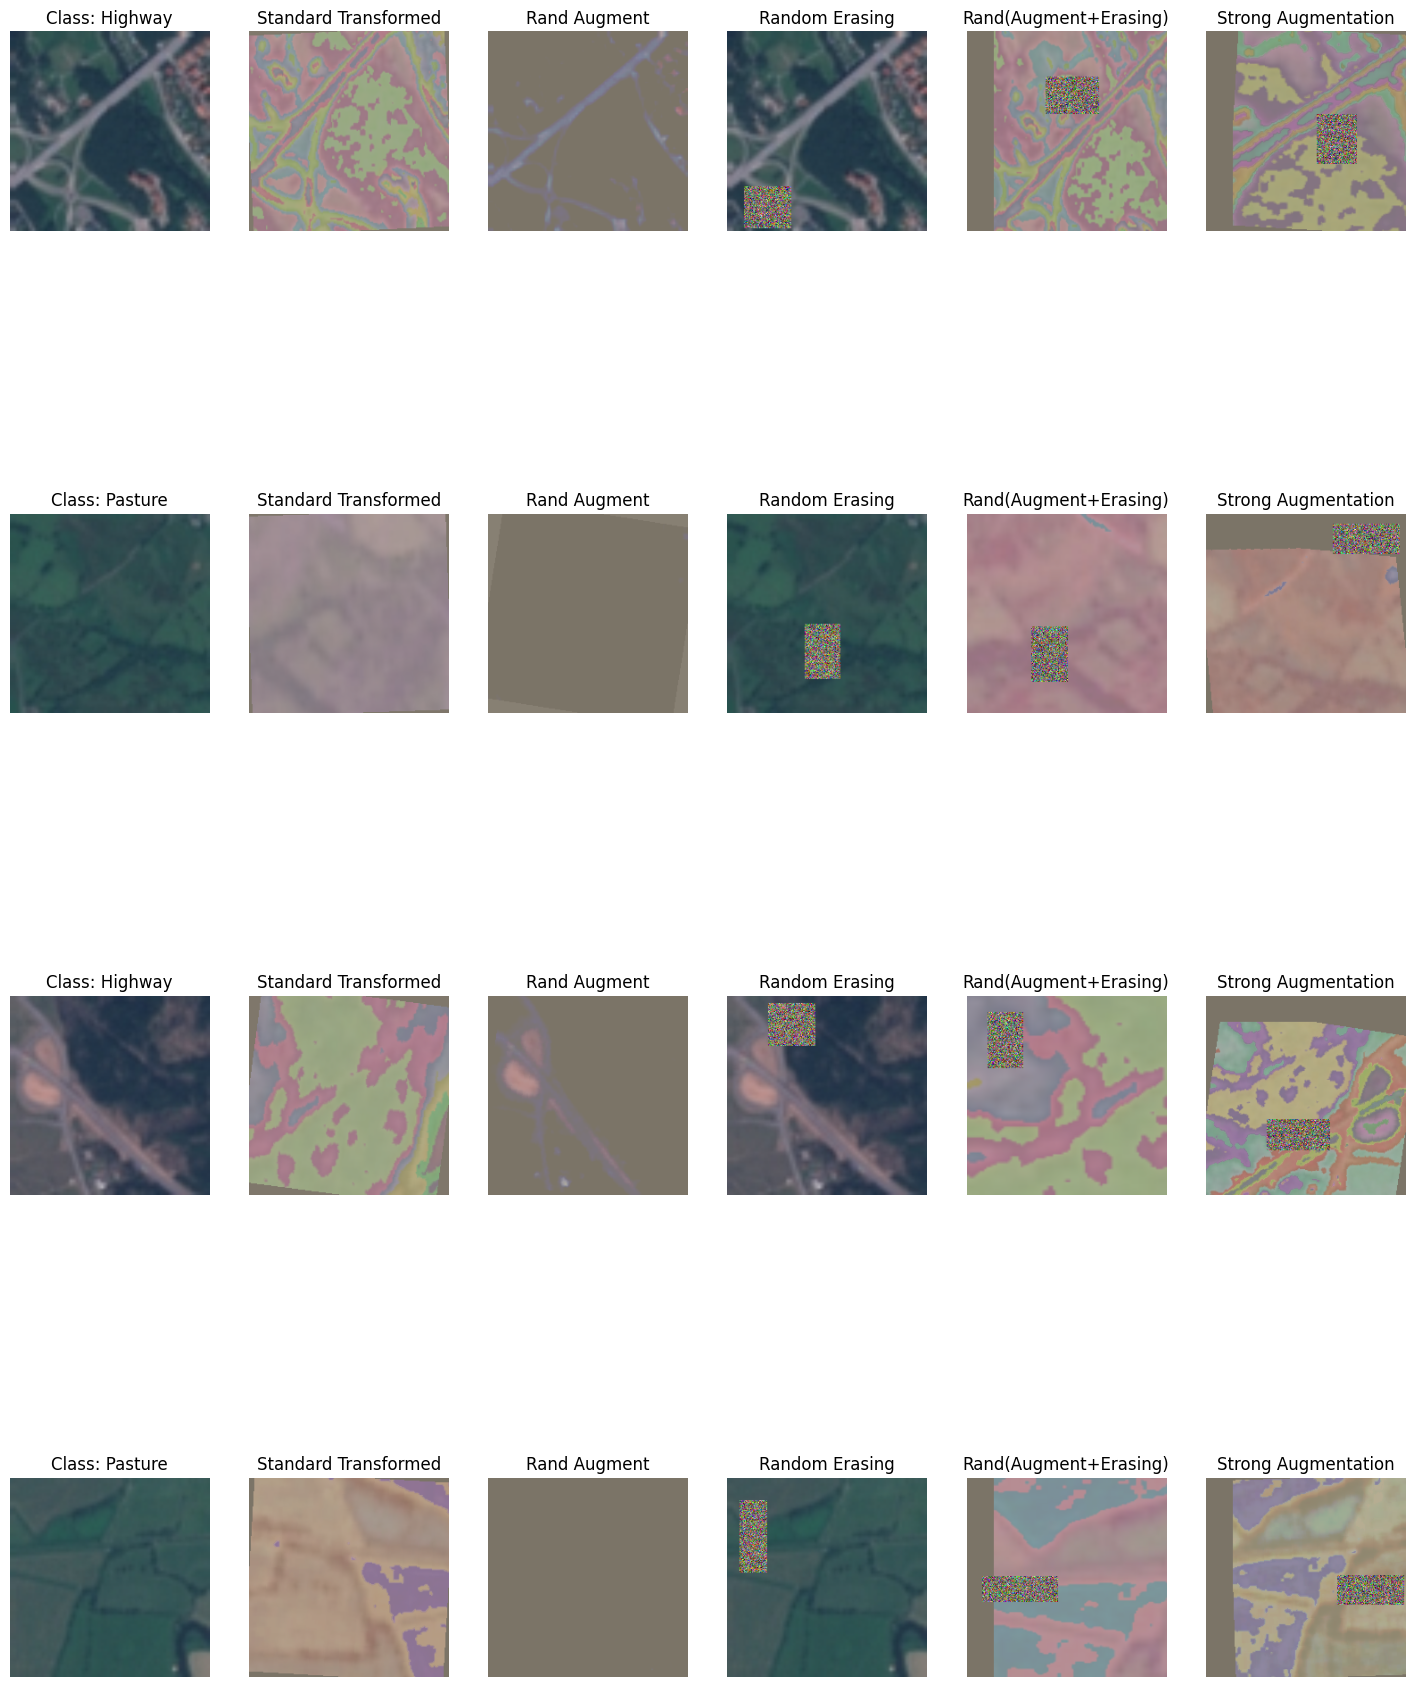

In [7]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image

# Global parameters
DATASET_PATH = 'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
BATCH_SIZE = 4  # Smaller batch size for visualization

# Define preprocessing transformations
preproc = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Define standard geometric transformations
standard_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, 'train'), transform=preproc)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Function to unnormalize and show images
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Class names
class_names = train_dataset.classes

# Define additional augmentations
rand_augment = v2.RandAugment()
# Define the Random Erasing transformation with adjusted parameters
random_erasing = v2.RandomErasing(p=1.0, scale=(0.05, 0.05), ratio=(0.3, 3.3), value='random', inplace=False)

# Data transformations
strong_augment = v2.Compose([
    v2.Resize(256),  # Resize to 256 as required by the model
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    rand_augment,
    transforms.ToTensor(),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    random_erasing
])

# Data transformations
strong_augment_all = v2.Compose([
    v2.Resize(256),  # Resize to 256 as required by the model
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.ToDtype(torch.float32, scale=True),
    rand_augment,
    transforms.ToTensor(),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    random_erasing
])



# Data augmentation methods
cutmix = v2.CutMix(num_classes=10)
mixup = v2.MixUp(num_classes=10)

# Apply augmentations
images_standard = torch.stack([standard_transforms(to_pil_image(img)) for img in images])
images_randaug = torch.stack([rand_augment(img) for img in images])
images_randerasi = torch.stack([random_erasing(img) for img in images])
images_strongaug = torch.stack([strong_augment(to_pil_image(img)) for img in images])
images_strongaug_all = torch.stack([strong_augment_all(to_pil_image(img)) for img in images])

# Show original and augmented images
plt.figure(figsize=(18, 24))
for i in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE, 6, i * 6 + 1)
    imshow(images[i], title=f"Class: {class_names[labels[i]]}")

    plt.subplot(BATCH_SIZE, 6, i * 6 + 2)
    imshow(images_standard[i], title="Standard Transformed")

    plt.subplot(BATCH_SIZE, 6, i * 6 + 3)
    imshow(images_randaug[i], title="Rand Augment")

    plt.subplot(BATCH_SIZE, 6, i * 6 + 4)
    imshow(images_randerasi[i], title="Random Erasing")

    plt.subplot(BATCH_SIZE, 6, i * 6 + 5)
    imshow(images_strongaug[i], title="Rand(Augment+Erasing)")

    plt.subplot(BATCH_SIZE, 6, i * 6 + 6)
    imshow(images_strongaug_all[i], title="Strong Augmentation")
plt.show()
